# Imports

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from IPython.display import display
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve


# Models Used
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

sn.set_theme(style="whitegrid")


In [2]:
# Old Excel file
# churn_data = pd.read_csv('/content/drive/MyDrive/HUA/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

# churn_data = pd.read_excel('/content/drive/MyDrive/HUA/CustomerChurn.xlsx', index_col='Customer ID')
# churn_telco = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn.xlsx', index_col='CustomerID')
# churn_demograph = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_demographics.xlsx', index_col='Customer ID') # joined
# churn_location = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_location.xlsx', index_col='Customer ID') # joined
# churn_pop = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_population.xlsx', index_col='Zip Code') # joined
# churn_services = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_services.xlsx', index_col='Customer ID') # joined
# churn_status = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_status.xlsx', index_col='Customer ID')


# Loading Data from external sources

In [4]:
# Old Excel file
# churn_data = pd.read_csv('/content/drive/MyDrive/HUA/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

churn_data = pd.read_excel('CustomerChurn.xlsx', index_col='Customer ID')
churn_telco = pd.read_excel('Telco_customer_churn.xlsx', index_col='CustomerID')
churn_demograph = pd.read_excel('Telco_customer_churn_demographics.xlsx', index_col='Customer ID') # joined
churn_location = pd.read_excel('Telco_customer_churn_location.xlsx', index_col='Customer ID') # joined
churn_pop = pd.read_excel('Telco_customer_churn_population.xlsx', index_col='Zip Code') # joined
churn_services = pd.read_excel('Telco_customer_churn_services.xlsx', index_col='Customer ID') # joined
churn_status = pd.read_excel('Telco_customer_churn_status.xlsx', index_col='Customer ID')

In [3]:
# churn_telco.info()
# churn_demograph.info()
# churn_location.info()
# churn_pop.info()
# churn_services.info()
# churn_status.info()


# Joining Data

In [5]:
demographic_cols = ['Gender','Age', 'Under 30', 'Married', 'Number of Dependents']
churn_data_no_total_charges = churn_data.drop(columns='Total Charges')

# Joining demographic data
updated_churn_data = churn_data_no_total_charges.join(churn_demograph[demographic_cols])

# Joining location data to help join population data
churn_with_loc = updated_churn_data.join(churn_location[['Zip Code', 'Latitude', 'Longitude', 'City']])

# Joining population data
updated_churn_data_zip = churn_with_loc.join(churn_pop, on='Zip Code')

# Calculating new column population to state population ration
updated_churn_data_zip['Population Percentage'] = updated_churn_data_zip['Population'] * 100 / 38940231

# Joining services data
churn_wservices = updated_churn_data_zip.join(churn_services.drop(['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'], axis=1))

# Droping column from final dataset
final_dataset = churn_wservices.drop(columns=['LoyaltyID', 'ID', 'Service ID', 'Count', 'Quarter'])



# Preprocessing and Transforming Data and Visualization

In [6]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

def mapYesNo(df):
  yes_no_dict = {'No': 0, 'Yes': 1}
  for col in df.columns:
    if set(df[col].unique()) == set(['No', 'Yes']) and col != 'Churn':
      df[col] = df[col].map(yes_no_dict)
  return df

final_dataset['Offer'].fillna('No Offer', inplace=True)
final_dataset['Internet Type'].fillna('No Internet', inplace=True)

final_dataset = mapYesNo(final_dataset)
final_dataset['Total Charges'] = final_dataset['Total Charges'].replace(',', '.')
final_dataset['Total Charges'] = final_dataset['Total Charges'].astype(np.float16)



C:\Users\futura\AppData\Local\Temp\ipykernel_16124\4119982284.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataset['Offer'].fillna('No Offer', inplace=True)
C:\Users\futura\AppData\Local\Temp\ipykernel_16124\4119982284.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [ ]:
# plt.figure(figsize=(14, 14))
# sn.swarmplot(final_dataset, x='Offer', y='Monthly Charges', size=3, hue='Churn')
# plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
sn.scatterplot(final_dataset, x='Longitude', y='Latitude', alpha=.5, hue='Churn')
plt.show()

In [ ]:
group_by_zip_people = final_dataset.groupby(by='City')['Churn'].count().reset_index()
group_by_zip_churn_type = final_dataset.groupby(by='City')['Churn'].value_counts().reset_index()
group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(7).plot(kind='bar', x='City', y='count')
cities_with_high_samples = group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(8)['City'].to_list()
plt.figure(figsize=(10, 5))
sn.countplot(final_dataset[final_dataset['City'].isin(cities_with_high_samples)], x='City', hue='Churn')


Dropping Columns that will not be need for for the machine learning algorithms

In [7]:
final_dataset = final_dataset.drop(columns=['Zip Code', 'Monthly Charge', 'Internet Service'])

In [ ]:
colName = "Internet Type"

g = sn.catplot(
    data=final_dataset, x=colName, y="Monthly Charges", hue="Churn",
    height=5, aspect=2, size=3
    )
g.set_axis_labels(colName, "Monthly Charges")
g.set_xticklabels(final_dataset[colName].unique())
g.set_titles("{col_name} {col_var}")


In [ ]:

colName2 = 'Internet Type'

g = sn.catplot(
    data=final_dataset,
    x=colName2,
    y="Total Charges",
    hue="Churn",
    height=5,
    aspect=1.5,
    size=2
    )
g.set_axis_labels(colName2, "Total Charges")
g.set_xticklabels(final_dataset[colName2].unique())
g.set_titles("{col_name} {col_var}")



In [ ]:
sn.histplot(final_dataset[final_dataset['Total Refunds'] != 0], x='Total Refunds', bins=50, hue='Churn',  multiple="stack"  )
plt.show()
print('\n')

sn.histplot(final_dataset[final_dataset['Total Refunds'] == 0], x='Total Refunds', bins=50, hue='Churn',  multiple="stack" )
plt.show()
print('\n')

sn.histplot(final_dataset, x='Monthly Charge', bins=20, hue='Churn', multiple="stack", log_scale=True )
plt.show()

In [ ]:
def plotMultiple(df, cols, size, figsize):

  fig, ax = plt.subplots(size[0], size[1], figsize=figsize)

  x=0
  y=0
  for col in cols:

    if col == 'Churn':
      continue
    sn.countplot(df, x=col, hue='Churn', ax=ax[x,y]).set(title=col, xlabel=None)
    plt.setp(ax[x, y].get_xticklabels(), rotation=30, fontsize='x-small')
    y += 1
    if y == size[1]:
      y = 0
      x += 1

  plt.tight_layout()
  plt.show()

final_df_objects = final_dataset.select_dtypes('object').drop(columns='City')

plotMultiple(final_df_objects, final_df_objects.columns[:9], (3, 3), (12, 12))
plotMultiple(final_df_objects, final_df_objects.columns[9:], (2, 2), (10, 10))

In [ ]:
final_dataset.select_dtypes(include=[int, float]).hist(bins=30, figsize=(14, 10))
sn.heatmap(final_dataset.select_dtypes(include=[int, float]).corr()['Tenure'])
plt.tight_layout()
final_dataset.info()
# plt.show()

# Create Heatmaps with categorical features and the class column

In [ ]:
def createHeatmaps(df):
  for col in df.select_dtypes('object'):
    if col not in 'Churn':
      dft = pd.crosstab(df["Churn"], df[col]).apply(func=lambda x : x / 7043 * 100).round(0)
      ax = sn.heatmap(dft, annot=True, fmt=".0f")
      for t in ax.texts: t.set_text(t.get_text() + "%")
      plt.show()
      print("\n")

# createHeatmaps(final_dataset)

# One Hot Encoding of categorical columns

In [85]:
def onehot_enc(df):
  for col in df.columns:
    if df[col].dtype == object and col not in ['Churn', 'City']:
      onehot = OneHotEncoder(sparse_output=False, drop='if_binary')
      onehot.fit(df[[col]])
      OH_cols_train = pd.DataFrame(onehot.transform(df[[col]]),
                                   columns=onehot.get_feature_names_out(),
                                   index=df.index)
      droped_cols = df.drop(columns=col, axis=1)
      df = pd.concat([droped_cols, OH_cols_train], axis=1)
  return df

def onehot_cities(df):
  column = 'City'
  onehot = OneHotEncoder(sparse_output=False)
  onehot.fit(df[[column]])
  OH_cols_train = pd.DataFrame(onehot.transform(df[[column]]),
                                columns=onehot.get_feature_names_out(),
                                index=df.index)
  droped_cols = df.drop(columns=[column], axis=1)
  df = pd.concat([droped_cols, OH_cols_train[['City_Los Angeles', 'City_San Diego']]], axis=1)
  return df



final_dataset_oh = onehot_enc(final_dataset)
final_dataset_oh = onehot_cities(final_dataset_oh)

# Removing Similar Columns to reduce multi collinearity
dup_cols = ['Online Security_No internet service', 'Tech Support_No internet service', 'Streaming Movies_No internet service', 'Online Backup_No internet service', 'Device Protection_No internet service']
final_dataset_oh.drop(columns=dup_cols, inplace=True)

y = final_dataset['Churn']
X = final_dataset_oh
X.drop(columns=['Churn'], inplace=True)
# X.info()


# Target Class Percentages

In [ ]:
# agro = final_dataset[['Churn']].value_counts() / 7043
# agro.plot(kind='bar')
# plt.show()
# print(agro)

# Train test split final dataset

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# Scaling data for for specific models

In [87]:
scale_columns = ['Tenure', 'Monthly Charges', 'Population', 'Population Percentage', 'Number of Referrals', 'Tenure in Months',
                 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Total Charges', 'Age', 'Number of Dependents',
                 'Total Long Distance Charges', 'Total Revenue', 'Total Refunds', 'Total Extra Data Charges']

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

scaler = StandardScaler()
X_train_norm[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test_norm[scale_columns] = scaler.transform(X_test[scale_columns])

# # Sequencial Feature Selection process features
# scale_columns_sfs = ['Tenure', 'Number of Referrals', 'Tenure in Months']

# X_train_fs = X_train_sfs.copy()
# X_test_fs = X_test_sfs.copy()

# scaler2 = StandardScaler()
# X_train_fs[scale_columns_sfs] = scaler2.fit_transform(X_train_sfs[scale_columns_sfs])
# X_test_fs[scale_columns_sfs] = scaler2.transform(X_test_sfs[scale_columns_sfs])


# # Selection From Model process features
# scale_columns_reduced = ['Tenure', 'Monthly Charges', 'Number of Referrals', 'Tenure in Months', 'Total Charges']

# X_train_sfm = X_train_reduced.copy()
# X_test_sfm = X_test_reduced.copy()

# scaler3 = StandardScaler()
# X_train_sfm[scale_columns_reduced] = scaler3.fit_transform(X_train_reduced[scale_columns_reduced])
# X_test_sfm[scale_columns_reduced] = scaler3.transform(X_test_reduced[scale_columns_reduced])


# Utility Functions

# Plotting Confusion Matrix and ROC Curve Function

In [63]:
def plot_confusion_matrix(model, X, y):
  titles_options = [
      ("Confusion matrix, without normalization", None),
      ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
          model,
          X,
          y,
          display_labels=y.unique(),
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)

      plt.show()
      print("\n")



In [153]:
random_state=42
def get_classifiers():
  clf_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'AdaBoost']
  clf_models = [DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state),
                XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2, booster='gbtree'), AdaBoostClassifier(random_state=random_state)]
  return dict(zip(clf_names, clf_models))

def get_classifiers_for_scaled_data():
  clf_names_scaled = ['Naive Bayes', 'K-Nearest Neighbor', 'Stochastic Gradient Descent', 'Logistic Regression']
  clf_models_for_scaled = [GaussianNB(), KNeighborsClassifier(), SGDClassifier(random_state=random_state), LogisticRegression(penalty="l1", solver="saga", tol=0.1)]
  return dict(zip(clf_names_scaled, clf_models_for_scaled))

# Evaluating Default Models Without Feature Selection

In [154]:
clfs_simple = get_classifiers()
clfs_scaled = get_classifiers_for_scaled_data()
clfs_not_scaled = get_classifiers_for_scaled_data()

# Train models that do not need scaled data
for name, model in (clfs_simple | clfs_not_scaled).items():
  print('Training ' + name)
  if name == 'XGBoost':
    start = time()
    model.fit(X_train, y_train=='Yes', eval_set=[(X_test_norm, y_test.map({'Yes': 1, 'No': 0}))])
  else:
    start = time()
    model.fit(X_train, y_train)
  print('Time to fit %.2f' % (time() - start))

# Train models that need scaled data
for name, model in clfs_scaled.items():
  print('Training ' + name)
  start = time()
  model.fit(X_train_norm, y_train)
  print('Time to fit %.2f' % (time() - start))



Training Decision Tree
Time to fit 0.14
Training Random Forest
Time to fit 1.80
Training Gradient Boosting
Time to fit 3.59
Training XGBoost
[0]	validation_0-logloss:0.52871
[1]	validation_0-logloss:0.48945
[2]	validation_0-logloss:0.47914
[3]	validation_0-logloss:0.47297
[4]	validation_0-logloss:0.46600
[5]	validation_0-logloss:0.47348
[6]	validation_0-logloss:0.46201
[7]	validation_0-logloss:0.46778
Time to fit 0.18
Training AdaBoost


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Time to fit 1.18
Training Naive Bayes
Time to fit 0.02
Training K-Nearest Neighbor
Time to fit 0.01
Training Stochastic Gradient Descent
Time to fit 0.14
Training Logistic Regression
Time to fit 0.06
Training Naive Bayes
Time to fit 0.03
Training K-Nearest Neighbor
Time to fit 0.01
Training Stochastic Gradient Descent
Time to fit 0.17
Training Logistic Regression
Time to fit 0.07


Predicting:  Decision Tree
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  XGBoost
Predicting:  AdaBoost
Predicting:  Naive Bayes
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


,scores
Decision Tree,0.764
Random Forest,0.820
Gradient Boosting,0.837
XGBoost,0.835
AdaBoost,0.836
Naive Bayes,0.781
K-Nearest Neighbor,0.781
Stochastic Gradient Descent,0.780
Logistic Regression,0.809


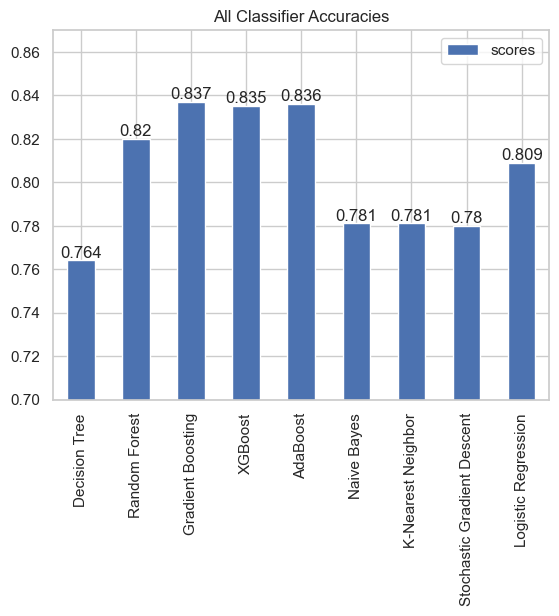

In [155]:
scores = {}
for name, model in clfs_simple.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test)
  if name == 'XGBoost':
    scores[name] = accuracy_score(y_test=='Yes', y_pred)
  else:
    scores[name] = accuracy_score(y_test, y_pred)

for name, model in clfs_scaled.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test_norm)
  scores[name] = accuracy_score(y_test, y_pred)

df_scores = pd.DataFrame({'scores': map(lambda x: round(x, 3), scores.values())},
                         index=scores.keys())
ax = df_scores.plot.bar()
plt.ylim((0.7, 0.87))
plt.title("All Classifier Accuracies")
ax.bar_label(ax.containers[0])
display(df_scores)


Predicting:  Naive Bayes
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


,No normalized,Normalized
Naive Bayes,0.73,0.78
K-Nearest Neighbor,0.73,0.78
Stochastic Gradient Descent,0.74,0.78
Logistic Regression,0.73,0.81


[Text(0, 0, '0.78'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.78'),
 Text(0, 0, '0.81')]

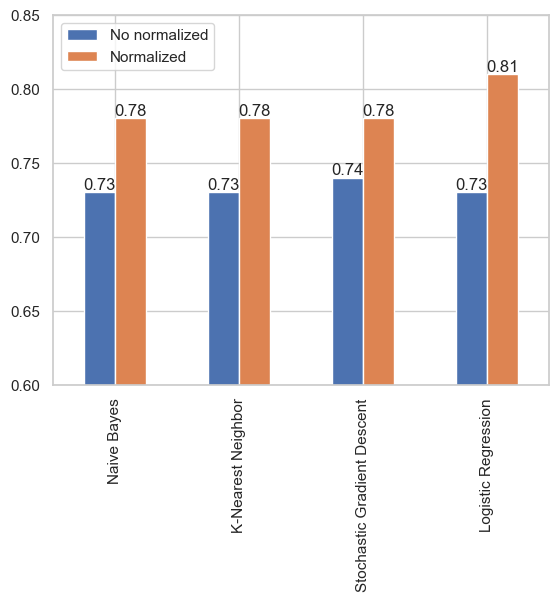

In [156]:
scores_not_normalized = {}
for name, model in clfs_not_scaled.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test)
  scores_not_normalized[name] = accuracy_score(y_test, y_pred)

df_not_normalized = pd.DataFrame({"No normalized": map(lambda x: round(x, 2), scores_not_normalized.values(), ),
                                  "Normalized": map(lambda x: round(x, 2), [scores[name] for name in scores_not_normalized.keys()])},
                                  index=scores_not_normalized.keys())

display(df_not_normalized)

ax = df_not_normalized.plot.bar()
plt.ylim((0.6, 0.85))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])




# Evaluating Model with SelectKBest Feature Selection method

In [158]:
kbest_scores = {}

## Decision Tree

In [ ]:
def kbest_dt(k_features):
  sel_k = SelectKBest(mutual_info_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train, y_train)
  X_test_k = sel_k.transform(X_test)

  dt = DecisionTreeClassifier(random_state=42)

  cv = StratifiedKFold(5)

  res = cross_validate(dt, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
  # print(f'K-features: {k_features} Accuracy: {res["test_score"].mean()}')
  return res["test_score"].mean()

dt_scores = {}
for k in range(1, len(X_train.columns)+1):
  dt_scores[k] = kbest_dt(k)

print(sorted(dt_scores.items(), key=lambda x: x[1], reverse=True))

best_result_kbest_dt = sorted(dt_scores.items(), key=lambda x: x[1], reverse=True)[0]
print("Best accuracy with k-features=%d, score=%.5f" % (best_result_kbest_dt[0], best_result_kbest_dt[1]))
plt.plot(dt_scores.values())
plt.title('Varying KBestFeatures Decision Tree')
plt.xlabel('K-Features')
plt.ylabel('Accuracy')

In [ ]:
from sklearn.pipeline import make_pipeline

# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[0])
}

cv = StratifiedKFold(3)
estimator = make_pipeline(SelectKBest(score_func=f_classif), DecisionTreeClassifier(random_state=42))

gscv_dt_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring='accuracy', verbose=3, )
start = time()
gscv_dt_kbest.fit(X_train, y_train)
print('Time to search: ', time() - start)
print(f"Best k features: {gscv_dt_kbest.best_params_}")

# Select K-features from GridSearchCV Best Param
sel_dt_kbest = SelectKBest(f_classif, k=gscv_dt_kbest.best_params_['selectkbest__k'])
sel_dt_kbest.fit(X_train, y_train)
X_train_dt_kbest = X_train[sel_dt_kbest.get_feature_names_out()]
X_test_dt_kbest = X_test[sel_dt_kbest.get_feature_names_out()]

best_dt_kbest = DecisionTreeClassifier(random_state=42)
best_dt_kbest.fit(X_train_dt_kbest, y_train)
best_dt_kbest_y_preds = best_dt_kbest.predict(X_test_dt_kbest)


### Decision Tree SelectKBest Metrics

In [190]:
print('Best parameters found:\n', gscv_dt_kbest.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, best_dt_kbest_y_preds))
print("Classification Report:")
print(classification_report(y_test, best_dt_kbest_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_dt_kbest.predict_proba(X_test_dt_kbest)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_dt_kbest, X_test_dt_kbest, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_dt_kbest, X_test_dt_kbest, y_test)

kbest_scores['Decision Tree'] = accuracy_score(y_test, best_dt_kbest_y_preds)


Best parameters found:
 {'selectkbest__k': 51}

 Decision Tree Performance:
Accuracy: 0.7572746628814763
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.82      0.83      1035
         Yes       0.54      0.60      0.57       374

    accuracy                           0.76      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.76      0.76      1409

ROC AUC Score:
0.7058578108450231




## Naive Bayes

[(26, np.float64(0.7657080130685373)), (28, np.float64(0.7657080130685373)), (27, np.float64(0.7657075402560436)), (41, np.float64(0.7655305507792738)), (43, np.float64(0.7653529308858457)), (60, np.float64(0.7649983215156476)), (25, np.float64(0.7649978487031541)), (42, np.float64(0.7649976910989896)), (45, np.float64(0.7648207016222197)), (61, np.float64(0.7648205440180551)), (31, np.float64(0.7646435545412852)), (51, np.float64(0.7646435545412851)), (53, np.float64(0.7646433969371207)), (55, np.float64(0.7646433969371207)), (58, np.float64(0.7646433969371207)), (29, np.float64(0.7646430817287916)), (62, np.float64(0.7646430817287916)), (24, np.float64(0.7646430817287915)), (30, np.float64(0.7644659346478571)), (59, np.float64(0.7644659346478571)), (46, np.float64(0.7644657770436927)), (40, np.float64(0.7644654618353636)), (64, np.float64(0.7644654618353636)), (50, np.float64(0.7642884723585937)), (52, np.float64(0.7642884723585937)), (56, np.float64(0.7642884723585937)), (57, np.flo

Text(0, 0.5, 'Accuracy')

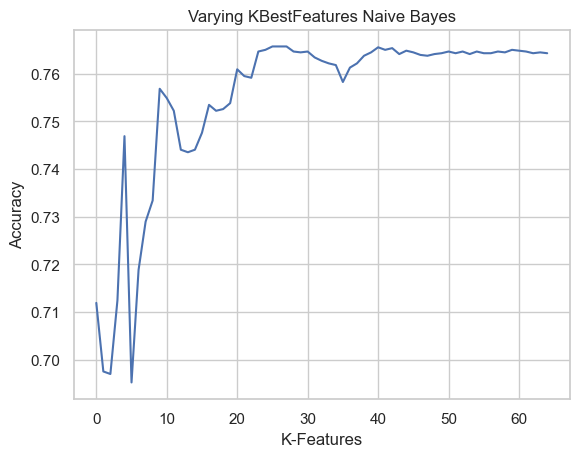

In [162]:
def kbest_nb(k_features):
  sel_k = SelectKBest(mutual_info_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  nb = GaussianNB()

  cv = StratifiedKFold(5)

  res = cross_validate(nb, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
  # print(f'K-features: {k_features} Accuracy: {res["test_score"].mean()}')
  return res["test_score"].mean()

nb_scores = {}
for k in range(1, len(X_train.columns)+1):
  nb_scores[k] = kbest_nb(k)

print(sorted(nb_scores.items(), key=lambda x: x[1], reverse=True))

best_result_kbest_nb = sorted(nb_scores.items(), key=lambda x: x[1], reverse=True)[0]
print("Best accuracy with k-features=%d, score=%.5f" % (best_result_kbest_nb[0], best_result_kbest_nb[1]))
plt.plot(nb_scores.values())
plt.title('Varying KBestFeatures Naive Bayes')
plt.xlabel('K-Features')
plt.ylabel('Accuracy')

In [164]:
nb_k_features = best_result_kbest_nb[0]
print(f"Best k features: {nb_k_features}")
sel_nb_kbest = SelectKBest(f_classif, k=nb_k_features)
sel_nb_kbest.fit_transform(X_train, y_train)
X_train_nb_kbest = X_train[sel_nb_kbest.get_feature_names_out()]
X_test_nb_kbest = X_test[sel_nb_kbest.get_feature_names_out()]

nb_kbest = GaussianNB()
nb_kbest.fit(X_train_nb_kbest, y_train)
nb_kbest_y_pred = nb_kbest.predict(X_test_nb_kbest)


print("\nDecision Tree Performance: ", k)
print("Accuracy:", accuracy_score(y_test, nb_kbest_y_pred))
print("Classification Report:")
print(classification_report(y_test, nb_kbest_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, nb_kbest.predict_proba(X_test_nb_kbest)[:, 1]))
print("\n")

kbest_scores['Naive Bayes'] = accuracy_score(y_test, nb_kbest_y_pred)

Best k features: 26

Decision Tree Performance:  65
Accuracy: 0.7856635911994322
Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.76      0.84      1035
         Yes       0.56      0.85      0.68       374

    accuracy                           0.79      1409
   macro avg       0.75      0.81      0.76      1409
weighted avg       0.84      0.79      0.80      1409

ROC AUC Score:
0.8725800201503526




## K-Nearest Neighbor

[(29, np.float64(0.8020945593466362)), (26, np.float64(0.8008524809259561)), (25, np.float64(0.7997878647945393)), (30, np.float64(0.7996092992761241)), (31, np.float64(0.7996085112553014)), (32, np.float64(0.7990754939708526)), (33, np.float64(0.7983662752304567)), (28, np.float64(0.7981910193994965)), (27, np.float64(0.798013557110233)), (37, np.float64(0.7967700602520722)), (41, np.float64(0.7958830640140835)), (36, np.float64(0.7957051289123264)), (35, np.float64(0.7953503619379638)), (42, np.float64(0.7941071802881321)), (40, np.float64(0.7933984343602296)), (34, np.float64(0.7932219176959532)), (38, np.float64(0.7928652594716163)), (21, np.float64(0.7923317693746739)), (39, np.float64(0.7921561983353846)), (44, np.float64(0.7910907941831454)), (48, np.float64(0.7905574616903677)), (23, np.float64(0.7903803146094333)), (20, np.float64(0.7903792113802816)), (52, np.float64(0.790379053776117)), (54, np.float64(0.790202064299347)), (24, np.float64(0.7900252324267416)), (43, np.float6

Text(0, 0.5, 'Accuracy')

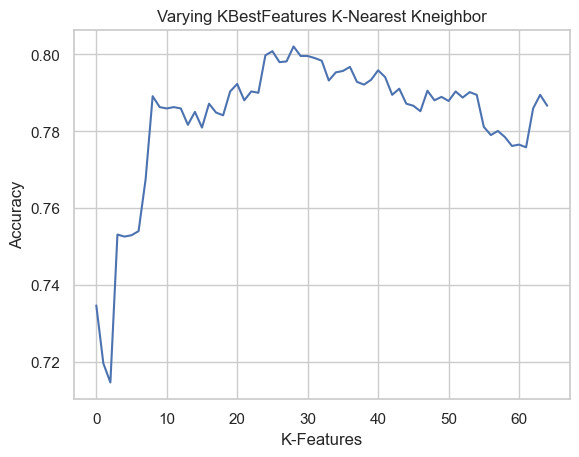

In [165]:
def kbest_knn(k_features):
  sel_k = SelectKBest(mutual_info_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  knn = KNeighborsClassifier()

  cv = StratifiedKFold(5)

  res = cross_validate(knn, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
  # print(f'K-features: {k_features} Accuracy: {res["test_score"].mean()}')
  return res["test_score"].mean()

knn_scores = {}
for k in range(1, len(X_train.columns)+1):
  knn_scores[k] = kbest_knn(k)

print(sorted(knn_scores.items(), key=lambda x: x[1], reverse=True))

best_result_kbest_knn = sorted(knn_scores.items(), key=lambda x: x[1], reverse=True)[0]
print("Best accuracy with k-features=%d, score=%.5f" % (best_result_kbest_knn[0], best_result_kbest_knn[1]))
plt.plot(knn_scores.values())
plt.title('Varying KBestFeatures K-Nearest Kneighbor')
plt.xlabel('K-Features')
plt.ylabel('Accuracy')

In [167]:
knn_k_features = best_result_kbest_knn[0]
print(f"Best k features: {knn_k_features}")
sel_knn_kbest = SelectKBest(f_classif, k=knn_k_features)
sel_knn_kbest.fit_transform(X_train, y_train)
X_train_knn_kbest = X_train[sel_knn_kbest.get_feature_names_out()]
X_test_knn_kbest = X_test[sel_knn_kbest.get_feature_names_out()]

knn_kbest = KNeighborsClassifier()
knn_kbest.fit(X_train_knn_kbest, y_train)
knn_kbest_y_pred = knn_kbest.predict(X_test_knn_kbest)

print("\nDecision Tree Performance: ", k)
print("Accuracy:", accuracy_score(y_test, knn_kbest_y_pred))
print("Classification Report:")
print(classification_report(y_test, knn_kbest_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, knn_kbest.predict_proba(X_test_knn_kbest)[:, 1]))
print("\n")


kbest_scores['K-Nearest Neighbor'] = accuracy_score(y_test, knn_kbest_y_pred)

Best k features: 29

Decision Tree Performance:  65
Accuracy: 0.7558552164655784
Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.88      0.84      1035
         Yes       0.55      0.42      0.48       374

    accuracy                           0.76      1409
   macro avg       0.68      0.65      0.66      1409
weighted avg       0.74      0.76      0.74      1409

ROC AUC Score:
0.717915730191945




## Stochastic Gradient Descent

[(52, np.float64(0.8177137624684596)), (30, np.float64(0.8175358273667024)), (42, np.float64(0.8170034404989119)), (35, np.float64(0.8159410308257986)), (32, np.float64(0.8152291328146054)), (54, np.float64(0.8141591581415947)), (38, np.float64(0.8138083312713456)), (31, np.float64(0.812921650241686)), (44, np.float64(0.8129211774291925)), (45, np.float64(0.8125657800381717)), (46, np.float64(0.8111470273490508)), (43, np.float64(0.8109687770389644)), (51, np.float64(0.8095500243498434)), (39, np.float64(0.8095473450790465)), (37, np.float64(0.8088397023802957)), (26, np.float64(0.8083098371791376)), (36, np.float64(0.8083082611374921)), (50, np.float64(0.807598096772109)), (41, np.float64(0.8074201616703519)), (25, np.float64(0.8065344262656795)), (33, np.float64(0.8049339559748528)), (27, np.float64(0.804223949213634)), (49, np.float64(0.8029768274596888)), (29, np.float64(0.802275646531684)), (47, np.float64(0.8022694999692671)), (34, np.float64(0.8017334882056923)), (60, np.float64

Text(0, 0.5, 'Accuracy')

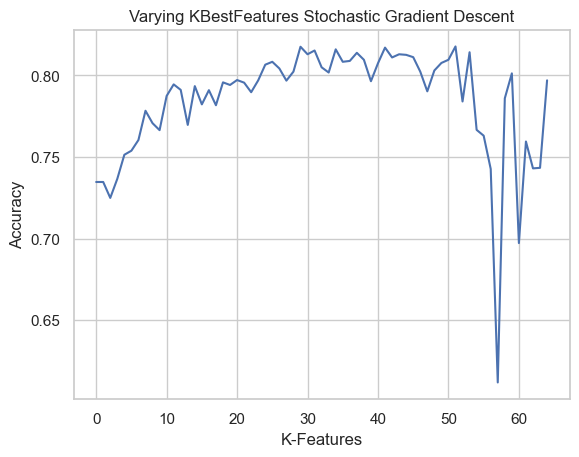

In [169]:
def kbest_sgd(k_features):
  sel_k = SelectKBest(mutual_info_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  sgd = SGDClassifier()

  cv = StratifiedKFold(5)

  res = cross_validate(sgd, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
  # print(f'K-features: {k_features} Accuracy: {res["test_score"].mean()}')
  return res["test_score"].mean()

sgd_scores = {}
for k in range(1, len(X_train.columns)+1):
  sgd_scores[k] = kbest_sgd(k)

print(sorted(sgd_scores.items(), key=lambda x: x[1], reverse=True))

best_result_kbest_sgd = sorted(sgd_scores.items(), key=lambda x: x[1], reverse=True)[0]
print("Best accuracy with k-features=%d, score=%.5f" % (best_result_kbest_sgd[0], best_result_kbest_sgd[1]))
plt.plot(sgd_scores.values())
plt.title('Varying KBestFeatures Stochastic Gradient Descent')
plt.xlabel('K-Features')
plt.ylabel('Accuracy')

In [170]:
sgd_k_features = best_result_kbest_sgd[0]
print(f"Best k features: {sgd_k_features}")
sel_sgd_kbest = SelectKBest(score_func=f_classif, k=sgd_k_features)
sel_sgd_kbest.fit_transform(X_train, y_train)
X_train_sgd_kbest = X_train[sel_sgd_kbest.get_feature_names_out()]
X_test_sgd_kbest = X_test[sel_sgd_kbest.get_feature_names_out()]

sgd_kbest = KNeighborsClassifier()
sgd_kbest.fit(X_train_sgd_kbest, y_train)
sgd_kbest_y_pred = sgd_kbest.predict(X_test_sgd_kbest)

print("\nStochastic Gradient Descent Performance: ", k)
print("Accuracy:", accuracy_score(y_test, sgd_kbest_y_pred))
print("Classification Report:")
print(classification_report(y_test, sgd_kbest_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, sgd_kbest.predict_proba(X_test_sgd_kbest)[:, 1]))
print("\n")


kbest_scores['Stochastic Gradient Descent'] = accuracy_score(y_test, sgd_kbest_y_pred)

Best k features: 52

Decision Tree Performance:  65
Accuracy: 0.7288857345635202
Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.86      0.82      1035
         Yes       0.49      0.36      0.41       374

    accuracy                           0.73      1409
   macro avg       0.64      0.61      0.62      1409
weighted avg       0.71      0.73      0.71      1409

ROC AUC Score:
0.671070035392286




## Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l1", solver="saga", tol=0.1)
lr.fit(X_train_norm, y_train)
y_pred = lr.predict(X_test_norm)


scores = cross_val_score(LogisticRegression(penalty="l1", solver="saga", tol=0.1), X_train_norm, y_train, cv=StratifiedKFold(5))
print(scores.mean())
print("\nDecision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, lr.predict_proba(X_test_norm)[:, 1]))
print("\n")


# plot_confusion_matrix(lr, X_test_norm, y_test)
# metrics.RocCurveDisplay.from_estimator(lr, X_test_norm, y_test)


0.8070642914668376

Decision Tree Performance:
Accuracy: 0.8097941802696949
Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.93      0.88      1035
         Yes       0.71      0.48      0.57       374

    accuracy                           0.81      1409
   macro avg       0.77      0.70      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC Score:
0.8671885091322432




# Decision Tree classifier

## Decision Tree

In [ ]:
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

scores = cross_val_score(dtc, X_train, y_train, cv=5)
scores.mean()
print("\nDecision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dtc_y_pred))
print("Classification Report:")
print(classification_report(y_test, dtc_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1]))
print("\n")


#Plot confusion matrix
# plot_confusion_matrix(dtc, X_test, y_test)

#Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(dtc, X_test, y_test)
# plt.show()



Decision Tree Performance:
Accuracy: 0.7721788502484032
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.84      0.84      1035
         Yes       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409

ROC AUC Score:
0.7151489317729728




## GridSearchCSV on Decision Tree

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters found:
 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'splitter': 'random'}

 Decision Tree Performance:
Accuracy: 0.8126330731014905
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.90      0.88      1035
         Yes       0.68      0.57      0.62       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

ROC AUC Score:
0.853859567542432


Confusion matrix, without normalization
[[933 102]
 [162 212]]


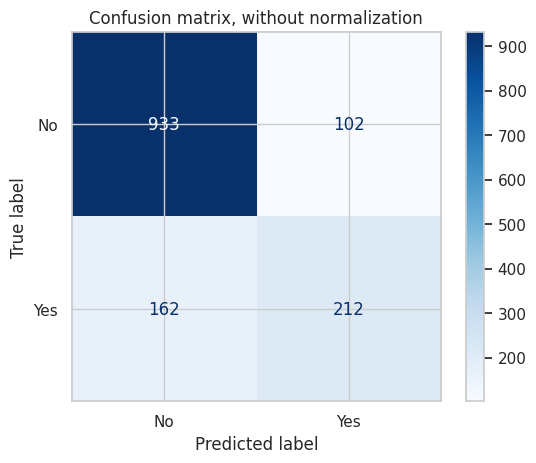



Normalized confusion matrix
[[0.90144928 0.09855072]
 [0.43315508 0.56684492]]


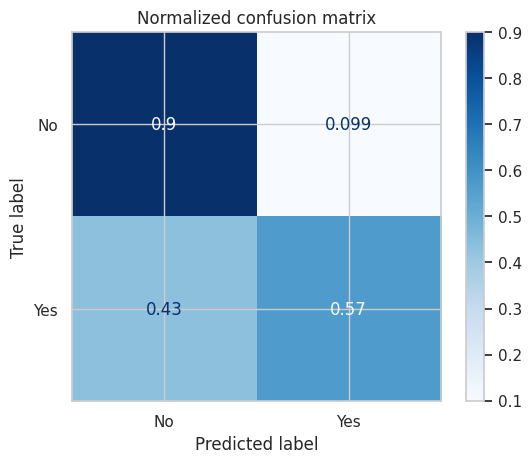

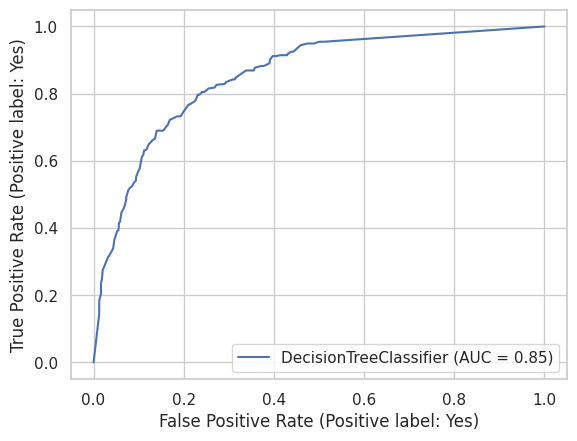

In [ ]:
from sklearn.metrics import roc_auc_score

parameter_space = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini'],
    'min_samples_leaf': [1, 10, 15, 16, 17, 20],
    'min_samples_split': [2, 5, 10, 20, 40],
    'splitter':['best','random']
}

dtc2 = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(5)

gscv = GridSearchCV(dtc2, parameter_space, n_jobs=-1, cv=cv, verbose=5)
gscv.fit(X_train, y_train)
best_dtc = gscv.best_estimator_

best_dtc_preds = best_dtc.predict(X_test)
print('Best parameters found:\n', gscv.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, best_dtc_preds))
print("Classification Report:")
print(classification_report(y_test, best_dtc_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_dtc.predict_proba(X_test)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_dtc, X_test, y_test)

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(best_dtc, X_test, y_test)


In [ ]:

result = np.c_[best_dtc.feature_names_in_, best_dtc.feature_importances_]
plt.figure(figsize=(10, 10))
# plt.barh(y=result[result[:10, 1].argsort()[::-1]][:, 0], width=result[result[:10, 1].argsort()[::-1]][:, 1])
plt.barh(y=result[result[:10, 1].argsort()][:, 0], width=result[result[:10, 1].argsort()][:, 1])
plt.show()

select_from_model = SelectFromModel(best_dtc, prefit=True)
X_reduced = select_from_model.fit_transform(X)
X_new = pd.DataFrame(X_reduced, columns=select_from_model.get_feature_names_out())

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_new, y, random_state=42, stratify=y, test_size=0.2)

# Search again after feature selection
parameter_space = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini', 'entropy'],
    'min_samples_leaf': [1, 10, 15, 16, 17],
    'min_samples_split': [2, 10, 20],
    'splitter':['best','random']
}

dtc3 = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(5)

gscv = GridSearchCV(dtc3, parameter_space, n_jobs=-1, cv=cv)
gscv.fit(X_train_reduced, y_train)
best_dtc3 = gscv.best_estimator_

best_dtc3_preds = best_dtc3.predict(X_test_reduced)
print('Best parameters found:\n', gscv.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, best_dtc3_preds))
print("Classification Report:")
print(classification_report(y_test, best_dtc3_preds))


# Plot confusion matrix
plot_confusion_matrix(best_dtc3, X_test_reduced, y_test)

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(best_dtc3, X_test_reduced, y_test)



## Recursice Feature Elimination with CV on Decision Tree

Optimal number of features: 32


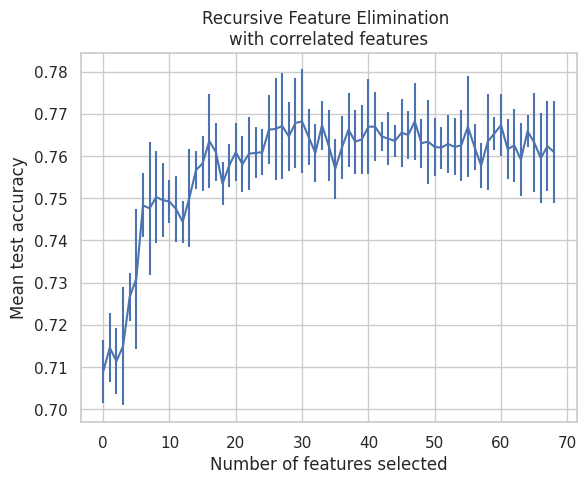

Best parameters found:
 {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 30, 'splitter': 'best'}

 Decision Tree Performance:
Accuracy: 0.8048261178140526
Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.87      0.87      1035
         Yes       0.63      0.62      0.63       374

    accuracy                           0.80      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC Score:
0.8638598258802863


Confusion matrix, without normalization
[[901 134]
 [141 233]]


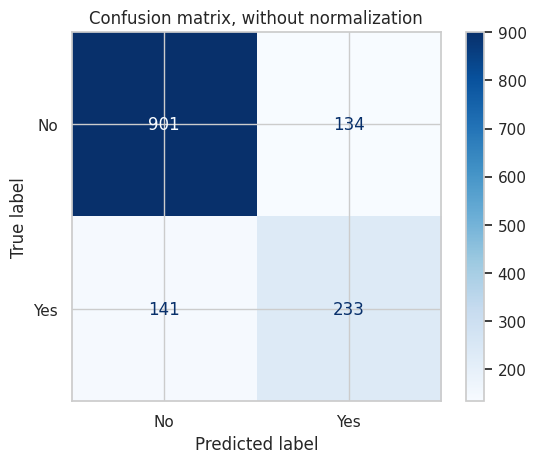



Normalized confusion matrix
[[0.8705314  0.1294686 ]
 [0.37700535 0.62299465]]


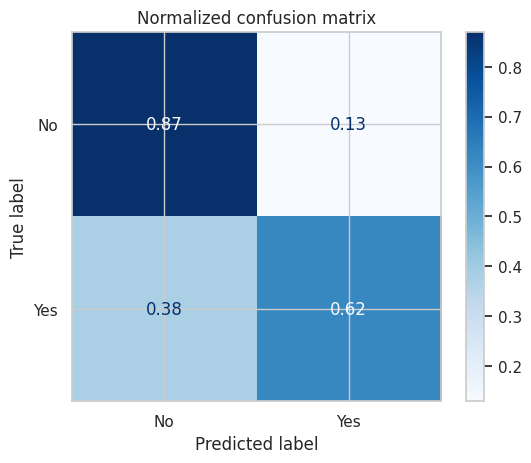

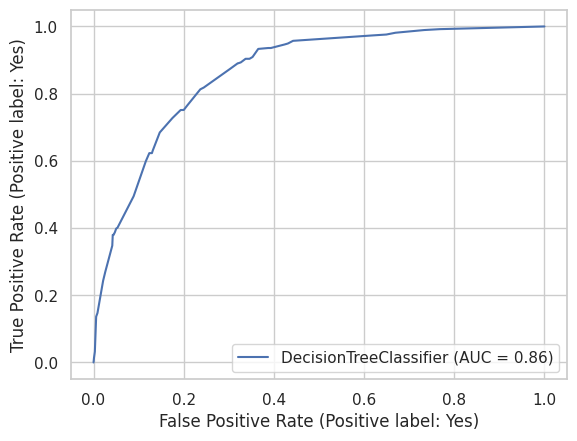

In [ ]:
min_features_to_select = 2  # Minimum number of features to consider
cv = StratifiedKFold(5)


rfecv = RFECV(
    estimator=DecisionTreeClassifier(random_state=42),
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

cv_results = pd.DataFrame(rfecv.cv_results_)
len(cv_results.mean_test_score)
cv_results
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results.mean_test_score,
    yerr=cv_results.std_test_score

)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

X_rfecv = rfecv.transform(X)
X_rfecv_new = pd.DataFrame(X_rfecv, columns=rfecv.get_feature_names_out())

X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = train_test_split(X_rfecv_new, y, random_state=42, stratify=y, test_size=0.2)

# Search again after feature selection
parameter_space = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini', 'entropy'],
    'min_samples_leaf': [1, 10, 15, 16, 17, 20],
    'min_samples_split': [2, 10, 20, 30],
    'splitter':['best','random']
}

dtc_rfecv = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(5)

gscv = GridSearchCV(dtc_rfecv, parameter_space, n_jobs=-1, cv=cv)
gscv.fit(X_train_rfecv, y_train_rfecv)
best_dtc_rfecv = gscv.best_estimator_

best_dtc_rfecv_preds = best_dtc_rfecv.predict(X_test_rfecv)
print('Best parameters found:\n', gscv.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test_rfecv, best_dtc_rfecv_preds))
print("Classification Report:")
print(classification_report(y_test_rfecv, best_dtc_rfecv_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_rfecv, best_dtc_rfecv.predict_proba(X_test_rfecv)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_dtc_rfecv, X_test_rfecv, y_test_rfecv)

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(best_dtc_rfecv, X_test_rfecv, y_test_rfecv)




## Sequencial Feature Selection on Decision Tree

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

feature_names = np.array(X.columns)

sfs_forward = SequentialFeatureSelector(
    DecisionTreeClassifier(random_state=42), direction="forward"
).fit(X_train, y_train)

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)

X_sfs = X[feature_names[sfs_forward.get_support()]]

X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs = train_test_split(X_sfs, y, random_state=42, stratify=y, test_size=0.2)

# Search again after feature selection
parameter_space = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini', 'entropy'],
    'min_samples_leaf': [1, 10, 15, 16, 17, 20],
    'min_samples_split': [45, 50],
    'splitter':['best','random']
}

dtc_sfs = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(5)

gscv = GridSearchCV(dtc_sfs, parameter_space, n_jobs=-1, cv=cv)
gscv.fit(X_train_sfs, y_train_sfs)
best_dtc_sfs = gscv.best_estimator_

best_dtc_sfs_preds = best_dtc_sfs.predict(X_test_sfs)

print('Best parameters found:\n', gscv.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test_sfs, best_dtc_sfs_preds))
print("Classification Report:")
print(classification_report(y_test_sfs, best_dtc_sfs_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_rfecv, best_dtc_sfs.predict_proba(X_test_sfs)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_dtc_sfs, X_test_sfs, y_test_sfs)

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(best_dtc_sfs, X_test_sfs, y_test_sfs)

Best parameters found:
 {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 45, 'splitter': 'best'}

 Decision Tree Performance:
Accuracy: 0.8204400283889283
Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1035
         Yes       0.69      0.59      0.64       374

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409

ROC AUC Score:
0.8672763440026867




# Naive Bayes Classifier

In [ ]:

gnb = GaussianNB()
gnb.fit(X_train_norm, y_train)
nb_y_pred = gnb.predict(X_test_norm)

accuracy = accuracy_score(y_test, nb_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, nb_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, gnb.predict_proba(X_test_norm)[:, 1]))
print("\n")

# Plot Confusion Matric
# plot_confusion_matrix(gnb, X_test, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(gnb, X_test, y_test)



Accuracy: 0.752306600425834
Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.71      0.81      1035
         Yes       0.52      0.86      0.65       374

    accuracy                           0.75      1409
   macro avg       0.73      0.79      0.73      1409
weighted avg       0.82      0.75      0.77      1409

ROC AUC Score:
0.8574853393267716




## GridSearchCV on Naive Bayes

In [ ]:
# params_NB = {'var_smoothing': np.logspace(0,-10, num=100)}
params_NB = {'alpha': np.logspace(0, 7, num=100)}

# gnb = GaussianNB()
gnb = BernoulliNB()
cv = StratifiedKFold(5)

gscv_gnb = GridSearchCV(gnb, params_NB, verbose=1, n_jobs=-1, cv=cv)
gscv_gnb.fit(X_train_norm, y_train)
best_gnb = gscv_gnb.best_estimator_

best_gnb_y_preds = best_gnb.predict(X_test_norm)

print('Best parameters found:\n', gscv_gnb.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, best_gnb_y_preds))
print("Classification Report:")
print(classification_report(y_test, best_gnb_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_gnb.predict_proba(X_test_norm)[:, 1]))
print("\n")


# Plot confusion matrix
# plot_confusion_matrix(best_gnb, X_test_norm, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_gnb, X_test_norm, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:
 {'alpha': 932.60334688322}

 Decision Tree Performance:
Accuracy: 0.8026969481902059
Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.87      0.87      1035
         Yes       0.63      0.62      0.63       374

    accuracy                           0.80      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC Score:
0.8397426954971713




## Naive Bayes with Feature Selection from Decision Tree

In [ ]:
# params_NB = {'var_smoothing': np.logspace(0,-10, num=100)}
# bnb = GaussianNB()

params_NB = {'alpha': np.logspace(0, 7, num=100)}
bnb = BernoulliNB()
cv = StratifiedKFold(5)

gscv_bnb = GridSearchCV(bnb, params_NB, verbose=1, n_jobs=-1, cv=cv)
gscv_bnb.fit(X_train_sfm.shape, y_train_reduced)
best_bnb = gscv_bnb.best_estimator_

best_bnb_y_preds = best_bnb.predict(X_test_sfm)

print('Best parameters found:\n', gscv_bnb.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test_reduced, best_bnb_y_preds))
print("Classification Report:")
print(classification_report(y_test_reduced, best_bnb_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_reduced, best_bnb.predict_proba(X_test_sfm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_bnb, X_test_sfm, y_test_reduced)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_bnb, X_test_sfm, y_test_reduced)

(5634, 15)

## Naive Bayes with Sequencial Feature Selection Features

In [ ]:
# params_NB = {'var_smoothing': np.logspace(0,-10, num=100)}
# bnb = GaussianNB()

params_NB = {'alpha': np.logspace(0, 7, num=100)}
bnb = BernoulliNB()
cv = StratifiedKFold(5)

gscv_bnb = GridSearchCV(bnb, params_NB, verbose=1, n_jobs=-1, cv=cv)
gscv_bnb.fit(X_train_fs, y_train_sfs)
best_bnb = gscv_bnb.best_estimator_

best_bnb_y_preds = best_bnb.predict(X_test_fs)

print('Best parameters found:\n', gscv_bnb.best_params_)

print("\n KNN Performance:")
print("Accuracy:", accuracy_score(y_test_sfs, best_bnb_y_preds))
print("Classification Report:")
print(classification_report(y_test_sfs, best_bnb_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_sfs, best_bnb.predict_proba(X_test_fs)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_bnb, X_test_fs, y_test_sfs)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_bnb, X_test_fs, y_test_sfs)

(5634, 35)

# KNN Classifier

In [ ]:
knn = KNeighborsClassifier()


knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

print("\n KNN Performance:")
print("Accuracy:", accuracy_score(y_test, knn_y_pred))
print("Classification Report:")
print(classification_report(y_test, knn_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(knn, X_test_norm, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(knn, X_test_norm, y_test)



 KNN Performance:
Accuracy: 0.730305180979418
Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.87      0.83      1035
         Yes       0.49      0.35      0.41       374

    accuracy                           0.73      1409
   macro avg       0.64      0.61      0.62      1409
weighted avg       0.71      0.73      0.71      1409

ROC AUC Score:
0.6709021157870263




## GridSearchCV on KNN

In [ ]:
params_KNN = {'n_neighbors': np.arange(10, 30),
              'leaf_size': [14, 15, 16, 20, 25],
              'p': [1, 2]
              }

knn = KNeighborsClassifier()
cv = StratifiedKFold(5)

gscv_knn = GridSearchCV(knn, params_KNN, verbose=4, n_jobs=-1, cv=cv)
gscv_knn.fit(X_train_norm, y_train)
best_knn = gscv_knn.best_estimator_

best_knn_y_preds = best_knn.predict(X_test_norm)

print('Best parameters found:\n', gscv_knn.best_params_)

print("\n KNN Performance:")
print("Accuracy:", accuracy_score(y_test, best_knn_y_preds))
print("Classification Report:")
print(classification_report(y_test, best_knn_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_knn.predict_proba(X_test_norm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_knn, X_test_norm, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_knn, X_test_norm, y_test)

Best parameters found:
 {'leaf_size': 14, 'n_neighbors': 16, 'p': 1}

 KNN Performance:
Accuracy: 0.8026969481902059
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC Score:
0.8570203311891291




## KNN with Selection From Model features Decision Tree

In [ ]:
params_KNN = {'n_neighbors': np.arange(2, 20, 30),
              'leaf_size': [10, 15, 20, 25],
              'p': [1, 2]}

knn = KNeighborsClassifier()
cv = StratifiedKFold(5)


gscv_knn = GridSearchCV(knn, params_KNN, verbose=1, n_jobs=-1, cv=cv)
gscv_knn.fit(X_train_sfm, y_train_reduced)
best_knn = gscv_knn.best_estimator_

best_knn_y_preds = best_knn.predict(X_test_sfm)

print('Best parameters found:\n', gscv_knn.best_params_)

print("\n KNN Performance:")
print("Accuracy:", accuracy_score(y_test_reduced, best_knn_y_preds))
print("Classification Report:")
print(classification_report(y_test_reduced, best_knn_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_reduced, best_knn.predict_proba(X_test_sfm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_knn, X_test_sfm, y_test_reduced)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_knn, X_test_sfm, y_test_reduced)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:
 {'leaf_size': 10, 'n_neighbors': 2, 'p': 1}

 Decision Tree Performance:
Accuracy: 0.8005677785663591
Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.94      0.87      1035
         Yes       0.72      0.40      0.52       374

    accuracy                           0.80      1409
   macro avg       0.77      0.67      0.70      1409
weighted avg       0.79      0.80      0.78      1409

ROC AUC Score:
0.7806969955307551




## KNN with Sequencial Feature Selection

In [ ]:
params_KNN = {'n_neighbors': np.arange(2, 25),
              'leaf_size': [15, 20, 25],
              'p': [1, 2]}

knn = KNeighborsClassifier()
cv = StratifiedKFold(5)

gscv_knn = GridSearchCV(knn, params_KNN, verbose=1, n_jobs=-1, cv=cv)
gscv_knn.fit(X_train_fs, y_train_sfs)
best_knn = gscv_knn.best_estimator_

best_knn_y_preds = best_knn.predict(X_test_sfs)

print('Best parameters found:\n', gscv_knn.best_params_)

print("\n Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test_sfs, best_knn_y_preds))
print("Classification Report:")
print(classification_report(y_test_sfs, best_knn_y_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test_sfs, best_knn.predict_proba(X_test_fs)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_knn, X_test_fs, y_test_sfs)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(best_knn, X_test_fs, y_test_sfs)

NameError: name 'X_train_fs' is not defined

# Stochastic Gradient Descent

Accuracy: 0.8225691980127751
Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.95      0.89      1035
         Yes       0.78      0.46      0.58       374

    accuracy                           0.82      1409
   macro avg       0.81      0.71      0.73      1409
weighted avg       0.82      0.82      0.81      1409

Confusion matrix, without normalization
[[987  48]
 [202 172]]


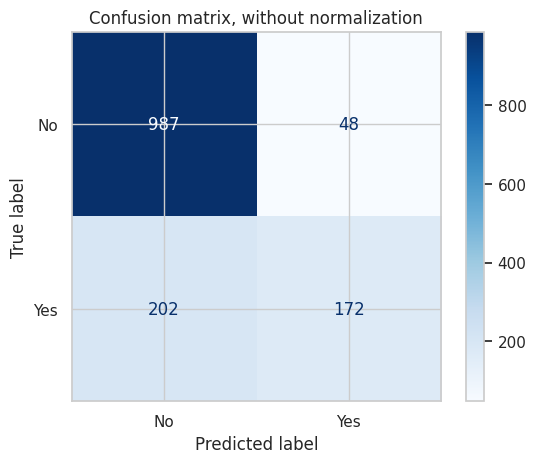



Normalized confusion matrix
[[0.95362319 0.04637681]
 [0.54010695 0.45989305]]


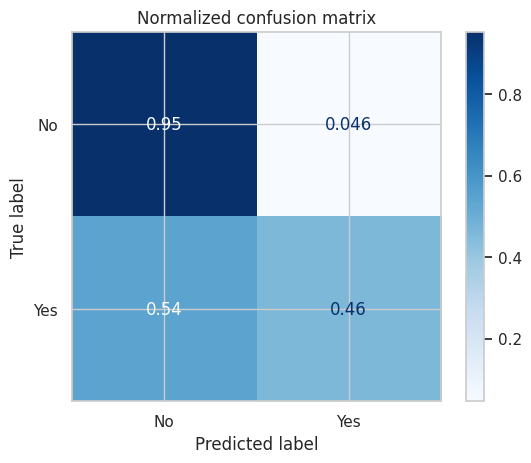

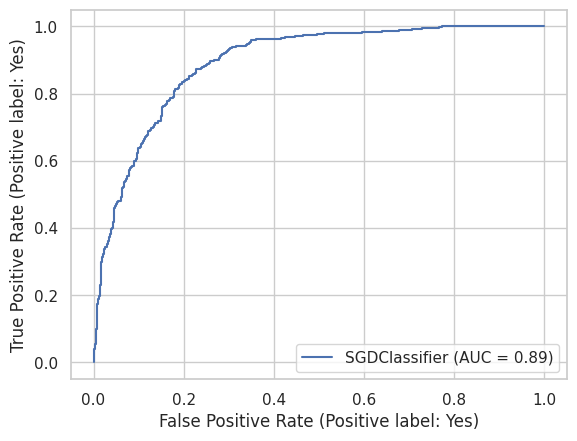

In [ ]:
sgd = SGDClassifier(random_state=42)

sgd.fit(X_train_norm, y_train)
sgd_y_pred = sgd.predict(X_test_norm)

accuracy = accuracy_score(y_test, sgd_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, sgd_y_pred, zero_division=0.0))

# Plot Confusion Matric
# plot_confusion_matrix(sgd, X_test_norm, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(sgd, X_test_norm, y_test)

Accuracy: 0.8246983676366217
Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.88      0.88      1035
         Yes       0.67      0.68      0.67       374

    accuracy                           0.82      1409
   macro avg       0.78      0.78      0.78      1409
weighted avg       0.83      0.82      0.83      1409

ROC AUC Score:


Confusion matrix, without normalization
[[909 126]
 [121 253]]


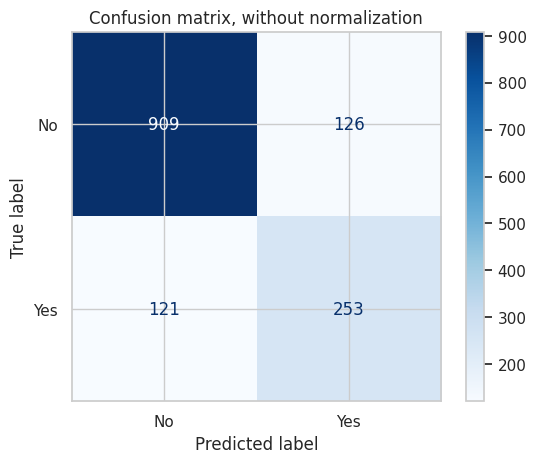



Normalized confusion matrix
[[0.87826087 0.12173913]
 [0.32352941 0.67647059]]


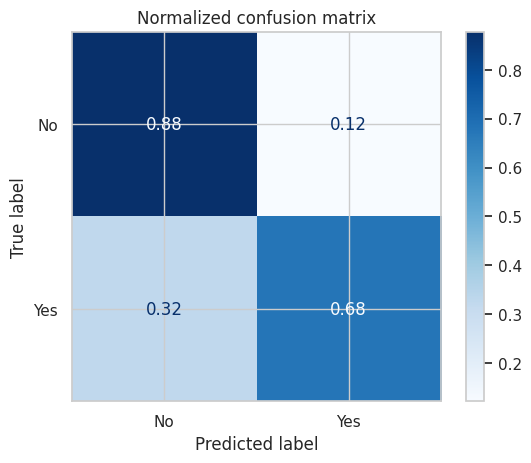



Accuracy: 0.8112136266855926
Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.83      0.87      1035
         Yes       0.62      0.76      0.68       374

    accuracy                           0.81      1409
   macro avg       0.76      0.79      0.77      1409
weighted avg       0.83      0.81      0.82      1409



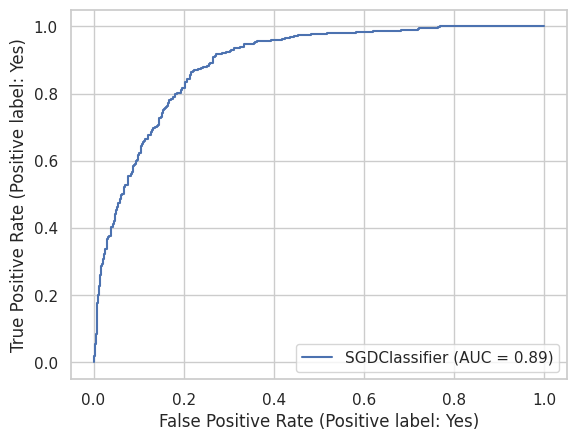

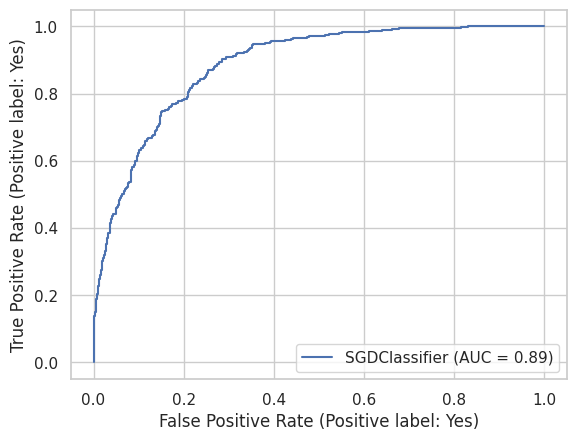

In [ ]:
sgd = SGDClassifier(random_state=42)

sgd.fit(X_train_norm, y_train)
sgd_y_pred = sgd.predict(X_test_norm)

accuracy = accuracy_score(y_test, sgd_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, sgd_y_pred, zero_division=0.0))

sgd.get_params()
# Plot Confusion Matric
plot_confusion_matrix(sgd, X_test_norm, y_test)

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(sgd, X_test_norm, y_test)
plt.plot()

select_from_model = SelectFromModel(sgd, prefit=True)
X_train_sgd_sfm = select_from_model.fit_transform(X_train_norm)
X_test_sgd_sfm = select_from_model.fit_transform(X_test_norm)

sgd = SGDClassifier(random_state=42)


sgd.fit(X_train_sgd_sfm, y_train)
sgd_y_pred_sfm = sgd.predict(X_test_sgd_sfm)

accuracy = accuracy_score(y_test, sgd_y_pred_sfm)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, sgd_y_pred_sfm, zero_division=0.0))

# Plot ROC Curve
metrics.RocCurveDisplay.from_estimator(sgd, X_test_sgd_sfm, y_test)

# Random Forest Classifier

In [ ]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

rf_y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, rf_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))
print("\n")

# Plot Confusion Matric
# plot_confusion_matrix(random_forest, X_test, y_test)

# Plot ROC Curve
# metrics.RocCurveDisplay.from_estimator(random_forest, X_test, y_test)

Accuracy: 0.8176011355571328
Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.92      0.88      1035
         Yes       0.71      0.53      0.61       374

    accuracy                           0.82      1409
   macro avg       0.78      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC Score:
0.8831977059598541




## Random Forest with Feature Selection From Model

## Utility function to report best scores

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [ ]:

select_from_model = SelectFromModel(random_forest,  prefit=True)
X_train_rf_sfm = select_from_model.fit_transform(X_train)
X_test_rf_sfm = select_from_model.transform(X_test)

rf_sfm = RandomForestClassifier(random_state=42)
rf_sfm.fit(X_train_rf_sfm, y_train)
pd.DataFrame(list(zip(select_from_model.get_feature_names_out(), rf_sfm.feature_importances_)), columns=['Feature', 'Importance'])
rf_y_pred = rf_sfm.predict(X_test_rf_sfm)

accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, rf_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, rf_sfm.predict_proba(X_test_rf_sfm)[:, 1]))
print("\n")


parameter_space = {
    'n_estimators': [160, 165],
    'criterion': ['log_loss', 'gini'],
    'min_samples_split': [2, 10, 12, 15, 20],
    'min_samples_leaf': [1, 10, 12, 15, 20],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt']
}


rf_gscv = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(5)


# run randomized search
n_iter_search = 25
gscv_rfc = RandomizedSearchCV(
    rf_gscv, param_distributions=parameter_space, n_iter=n_iter_search, verbose=1, cv=cv
)

# fit Search
start = time()
gscv_rfc.fit(X_train_rf_sfm, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)

# Print Report
report(gscv_rfc.cv_results_)

best_rfc = gscv_rfc.best_estimator_

best_rfc_preds = best_rfc.predict(X_test_rf_sfm)
print('Best parameters found:\n', gscv_rfc.best_params_)
accuracy_score(y_test, best_rfc_preds)

accuracy = accuracy_score(y_test, best_rfc_preds)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, best_rfc_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_rfc.predict_proba(X_test_rf_sfm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(best_rfc, X_test_rf_sfm, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(best_rfc, X_test_rf_sfm, y_test, alpha=0.8)



Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=12, min_samples_split=20, n_estimators=160;, score=0.824 total time=   2.1s
[CV 2/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=12, min_samples_split=20, n_estimators=160;, score=0.816 total time=   2.1s
[CV 3/3] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=12, min_samples_split=20, n_estimators=160;, score=0.818 total time=   1.7s
[CV 1/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=160;, score=0.823 total time=   1.5s
[CV 2/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=160;, score=0.813 total time=   1.5s
[CV 3/3] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=160;, score=0.818 total time=   1.5s
[CV 1/3] 

## RandomizedSearchCV on Random Forest Classifier

In [ ]:
def cv_random_forest_kbest(k_features):
  sel_k = SelectKBest(f_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train, y_train)
  X_test_k = sel_k.transform(X_test)

  rf = RandomForestClassifier(random_state=42)

  cv = StratifiedKFold(5)

  res = cross_validate(rf, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_estimator=True, return_train_score=True)
  print(f'K-features: {k_features} Accuracy: {res["train_score"].mean()}')
  return res["train_score"].mean()

In [ ]:
rf_scores = {}
for k in range(1, len(X_train.columns)+1):
  rf_scores[k] = cv_random_forest_kbest(k)

print(rf_scores)
plt.plot(rf_scores.values())


sel_k = SelectKBest(f_classif, k=35)
X_train_rf_k = sel_k.fit_transform(X_train, y_train)
X_test_rf_k = sel_k.transform(X_test)

# Feature scores
k_scores = pd.DataFrame(list(zip(sel_k.feature_names_in_, sel_k.scores_)), columns=['Feature', 'Score'])
print(k_scores.sort_values('Score', ascending=False).iloc[:40].to_string())


parameter_space = {
    'n_estimators': [160, 165],
    'criterion': ['log_loss', 'gini'],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [10, 15, 20, 30],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt']
}

rf_gscv = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(5)

# run randomized search
n_iter_search = 25
rscv_rfc = RandomizedSearchCV(
    rf_gscv, param_distributions=parameter_space, n_iter=n_iter_search, verbose=1, cv=cv
)

# fit Search
start = time()
rscv_rfc.fit(X_train_rf_k, y_train)
end = time()
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((end - start), n_iter_search)
)

# Print Report
report(rscv_rfc.cv_results_)

best_rfc_k = rscv_rfc.best_estimator_

best_rfc_k_preds = best_rfc_k.predict(X_test_rf_k)
print('Best parameters found:\n', rscv_rfc.best_params_)
accuracy_score(y_test, best_rfc_k_preds)

accuracy = accuracy_score(y_test, best_rfc_k_preds)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, best_rfc_k_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_rfc_k.predict_proba(X_test_rf_k)[:, 1]))
print("\n")

                                   Feature        Score
50                 Contract_Month-to-month  1031.664418
17                        Tenure in Months   768.594298
3                                   Tenure   765.721550
32                      Online Security_No   726.775884
41                         Tech Support_No   713.645300
52                       Contract_Two year   559.356563
55         Payment Method_Electronic check   534.074670
66               Internet Type_Fiber Optic   505.044489
16                     Number of Referrals   497.874977
35                        Online Backup_No   439.546297
38                    Device Protection_No   368.978019
33     Online Security_No internet service   318.042624
36       Online Backup_No internet service   318.042624
39   Device Protection_No internet service   318.042624
48    Streaming Movies_No internet service   318.042624
42        Tech Support_No internet service   318.042624
45        Streaming TV_No internet service   318

# Grandient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train_norm, y_train)
gbc_y_pred = gbc.predict(X_test_norm)

accuracy = accuracy_score(y_test, gbc_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, gbc_y_pred))

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_norm, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(gbc, X_test_norm, y_test, alpha=0.8)

Accuracy: 0.837473385379702
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.92      0.89      1035
         Yes       0.73      0.62      0.67       374

    accuracy                           0.84      1409
   macro avg       0.80      0.77      0.78      1409
weighted avg       0.83      0.84      0.83      1409



In [ ]:
def cv_gbc_kbest(k_features):
  sel_k = SelectKBest(f_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  rf = GradientBoostingClassifier(random_state=42)

  cv = StratifiedKFold(5)

  res = cross_validate(rf, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_estimator=True, return_train_score=True)
  print(f'K-features: {k_features} Accuracy: {res["train_score"].mean()}')
  return res["train_score"].mean()

Accuracy: 0.8410220014194464
Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.91      0.89      1035
         Yes       0.73      0.64      0.68       374

    accuracy                           0.84      1409
   macro avg       0.80      0.78      0.79      1409
weighted avg       0.84      0.84      0.84      1409



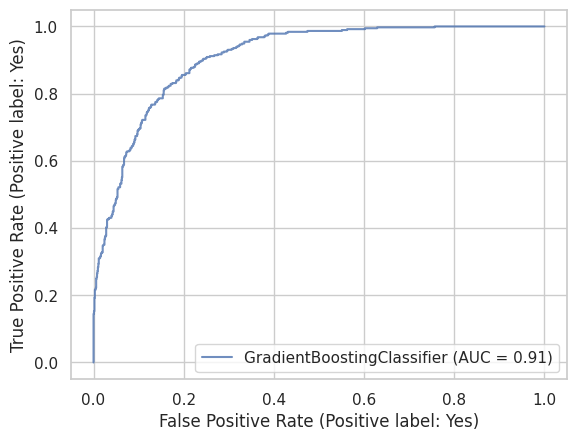

In [ ]:
gbc_scores = {}
for k in range(1, len(X_train.columns)+1):
  gbc_scores[k] = cv_gbc_kbest(k)

print(gbc_scores)
plt.plot(gbc_scores.values())

sel_k = SelectKBest(f_classif, k=39)
X_train_gbc_k = sel_k.fit_transform(X_train_norm, y_train)
X_test_gbc_k = sel_k.transform(X_test_norm)

gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train_gbc_k, y_train)
gbc_y_pred = gbc.predict(X_test_gbc_k)

accuracy = accuracy_score(y_test, gbc_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, gbc_y_pred))

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_gbc_k, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(gbc, X_test_gbc_k, y_test, alpha=0.8)




## RandomizedSearchCV Gradient Boosting Classifier

In [ ]:
sel_k = SelectKBest(f_classif, k=45)
X_train_gbc_k_norm = sel_k.fit_transform(X_train_norm, y_train)
X_test_gbc_k_norm = sel_k.transform(X_test_norm)

gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train_gbc_k_norm, y_train)
gbc_y_pred = gbc.predict(X_test_gbc_k_norm)

accuracy = accuracy_score(y_test, gbc_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, gbc_y_pred))

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_norm, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(gbc, X_test_norm, y_test, alpha=0.8)

parameter_space = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
    'max_features' : list(range(1,X_train_gbc_k_norm.shape[1]))
}

gbc_gscv = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(5)

# run randomized search
n_iter_search = 35
rscv_gbc = RandomizedSearchCV(
    gbc_gscv, param_distributions=parameter_space, n_iter=n_iter_search, verbose=3, cv=cv
)

# fit Search
start = time()
rscv_gbc.fit(X_train_gbc_k_norm, y_train)
end = time()
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((end - start), n_iter_search)
)

# Print Report
report(rscv_gbc.cv_results_)

best_gbc_k = rscv_gbc.best_estimator_

best_gbc_k_preds = best_gbc_k.predict(X_test_gbc_k_norm)
print('Best parameters found:\n', rscv_gbc.best_params_)
accuracy_score(y_test, best_gbc_k_preds)

accuracy = accuracy_score(y_test, best_gbc_k_preds)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, best_gbc_k_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_gbc_k.predict_proba(X_test_gbc_k_norm)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(gbc, X_test_gbc_k_norm, y_test)

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(gbc, X_test_gbc_k_norm, y_test, alpha=0.8)


Accuracy: 0.843860894251242
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.92      0.90      1035
         Yes       0.74      0.64      0.68       374

    accuracy                           0.84      1409
   macro avg       0.81      0.78      0.79      1409
weighted avg       0.84      0.84      0.84      1409



# XGBoost classifier

## Simple XGBoost

In [ ]:
import xgboost as xgb

# Use "hist" for constructing the trees, with early stopping enabled.
xgb_clf = xgb.XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2, booster='gbtree')

# Fit the model, test sets are used for early stopping.
xgb_clf.fit(X_train_norm, y_train.map({'Yes': 1, 'No': 0}), eval_set=[(X_test_norm, y_test.map({'Yes': 1, 'No': 0}))])
xgb_y_pred = xgb_clf.predict(X_test_norm)

accuracy_score(y_test.map({'Yes': 1, 'No': 0}), xgb_y_pred)
# Save model into JSON format.
# xgb_clf.save_model("clf.json")

accuracy = accuracy_score(y_test=='Yes', xgb_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test=='Yes', xgb_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, xgb_clf.predict_proba(X_test_norm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(xgb_clf, X_test_norm, y_test=='Yes')

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_norm, y_test=='Yes', alpha=0.8)

# Printing feature importance for XGBoost classifier
# print(pd.DataFrame(list(zip(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)), columns=['feat', 'impo']).sort_values(by='impo', ascending=False).to_string())


ROC AUC Score:
0.9000038750678137




## Finding the best K features with cross validation for XGBoost

In [ ]:
def cv_xgb_kbest(k_features):
  sel_k = SelectKBest(f_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  xgb = XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=42)

  cv = StratifiedKFold(5)

  res = cross_validate(xgb, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1 , return_estimator=True, return_train_score=True)
  print(f'K-features: {k_features} Accuracy: {res["train_score"].mean()}')
  return res["train_score"].mean()

gbc_scores = {}
xgb_scores = gbc_scores
for k in range(1, len(X_train.columns)+1):
  gbc_scores[k] = cv_gbc_kbest(k)

print(sorted(xgb_scores.items(), key=lambda x: x[1], reverse=True))
plt.plot(xgb_scores.values())

In [82]:

sel_k = SelectKBest(f_classif, k=39)
dup_cols = ['Online Security_No internet service', 'Tech Support_No internet service', 'Streaming Movies_No internet service', 'Online Backup_No internet service', 'Device Protection_No internet service']
X_train_xgb_k_norm = sel_k.fit_transform(X_train_norm, y_train)
X_test_xgb_k_norm = sel_k.transform(X_test_norm)

# Reduced dataset without duplicate columns
X_train_xgb_k_norm1 = pd.DataFrame(X_train_xgb_k_norm, columns=sel_k.get_feature_names_out())
X_test_xgb_k_norm1 = pd.DataFrame(X_test_xgb_k_norm, columns=sel_k.get_feature_names_out())

sorted(dict(zip(sel_k.get_feature_names_out(), sel_k.scores_)).items(), reverse=True, key=lambda x: x[1] )

# Use "hist" for constructing the trees, with early stopping enabled.
xgb_clf_kbest = XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2)

# Fit the model, test sets are used for early stopping.
xgb_clf_kbest.fit(X_train_xgb_k_norm, y_train.map({'Yes': 1, 'No': 0}), eval_set=[(X_test_xgb_k_norm, y_test.map({'Yes': 1, 'No': 0}))])
xgb_y_pred = xgb_clf_kbest.predict(X_test_xgb_k_norm)

accuracy_score(y_test.map({'Yes': 1, 'No': 0}), xgb_y_pred)
# Save model into JSON format.
# xgb_clf_kbest.save_model("clf.json")

accuracy = accuracy_score(y_test=='Yes', xgb_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test=='Yes', xgb_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, xgb_clf_kbest.predict_proba(X_test_xgb_k_norm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_fs, y_test)

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(xgb_clf_kbest, X_test_xgb_k_norm, y_test=='Yes', alpha=0.8)



NameError: name 'xgb' is not defined

[0]	validation_0-logloss:0.48820
[1]	validation_0-logloss:0.43796
[2]	validation_0-logloss:0.40464
[3]	validation_0-logloss:0.38134
[4]	validation_0-logloss:0.36639
[5]	validation_0-logloss:0.35722
[6]	validation_0-logloss:0.35230
[7]	validation_0-logloss:0.34741
[8]	validation_0-logloss:0.34315
[9]	validation_0-logloss:0.34269
[10]	validation_0-logloss:0.33842
[11]	validation_0-logloss:0.33836
[12]	validation_0-logloss:0.33832
[13]	validation_0-logloss:0.33663
[14]	validation_0-logloss:0.33667
[15]	validation_0-logloss:0.33795
Accuracy: 0.8353442157558553
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.91      0.89      1035
        True       0.71      0.63      0.67       374

    accuracy                           0.84      1409
   macro avg       0.79      0.77      0.78      1409
weighted avg       0.83      0.84      0.83      1409

ROC AUC Score:
0.9040869048541682




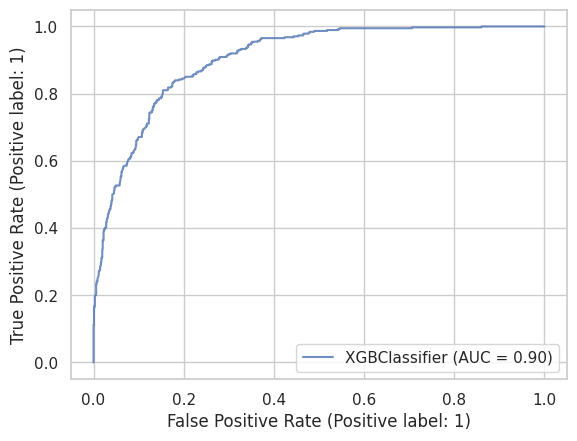

In [ ]:
select_from_model_xgb = SelectFromModel(xgb_clf, prefit=True)
X_train_xgb_sfm = select_from_model_xgb.fit_transform(X_train)
X_test_xgb_sfm = select_from_model_xgb.transform(X_test)

# Use "hist" for constructing the trees, with early stopping enabled.
xgb_clf_sfm = xgb.XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2)

# Fit the model, test sets are used for early stopping.
xgb_clf_sfm.fit(X_train_xgb_sfm, y_train.map({'Yes': 1, 'No': 0}), eval_set=[(X_test_xgb_sfm, y_test.map({'Yes': 1, 'No': 0}))])
xgb_y_pred = xgb_clf_sfm.predict(X_test_xgb_sfm)

accuracy_score(y_test.map({'Yes': 1, 'No': 0}), xgb_y_pred)
# Save model into JSON format.
# xgb_clf_sfm.save_model("clf.json")

accuracy = accuracy_score(y_test=='Yes', xgb_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test=='Yes', xgb_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, xgb_clf_sfm.predict_proba(X_test_xgb_sfm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_fs, y_test)

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(xgb_clf_sfm, X_test_xgb_sfm, y_test=='Yes', alpha=0.8)


In [ ]:
select_from_model_xgbk = SelectFromModel(xgb_clf_kbest, prefit=True)
X_train_xgbk_sfm = select_from_model_xgbk.fit_transform(X_train_xgb_k_norm)
X_test_xgbk_sfm = select_from_model_xgbk.transform(X_test_xgb_k_norm)

# Use "hist" for constructing the trees, with early stopping enabled.
xgb_clf_sfm = xgb.XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2)

# Fit the model, test sets are used for early stopping.
xgb_clf_sfm.fit(X_train_xgbk_sfm, y_train.map({'Yes': 1, 'No': 0}), eval_set=[(X_test_xgbk_sfm, y_test.map({'Yes': 1, 'No': 0}))])
xgb_y_pred = xgb_clf_sfm.predict(X_test_xgbk_sfm)

accuracy_score(y_test.map({'Yes': 1, 'No': 0}), xgb_y_pred)
# Save model into JSON format.
# xgb_clf_sfm.save_model("clf.json")

accuracy = accuracy_score(y_test=='Yes', xgb_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test=='Yes', xgb_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, xgb_clf_k.predict_proba(X_test_xgbk_sfm)[:, 1]))
print("\n")

# Plot confusion matrix
# plot_confusion_matrix(gbc, X_test_fs, y_test)

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(xgb_clf_k, X_test_xgbk_sfm, y_test=='Yes', alpha=0.8)

[0]	validation_0-logloss:0.49063
[1]	validation_0-logloss:0.44473
[2]	validation_0-logloss:0.41543
[3]	validation_0-logloss:0.39567
[4]	validation_0-logloss:0.38287
[5]	validation_0-logloss:0.37467
[6]	validation_0-logloss:0.36843
[7]	validation_0-logloss:0.36333
[8]	validation_0-logloss:0.36045
[9]	validation_0-logloss:0.35764
[10]	validation_0-logloss:0.35671
[11]	validation_0-logloss:0.35640
[12]	validation_0-logloss:0.35580
[13]	validation_0-logloss:0.35454
[14]	validation_0-logloss:0.35470
[15]	validation_0-logloss:0.35446
[16]	validation_0-logloss:0.35369
[17]	validation_0-logloss:0.35307
[18]	validation_0-logloss:0.35328


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=2, ...)

## GridSearchCV on XGBoost

Model with rank: 1
Mean validation score: 0.840 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.839 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 64}

Model with rank: 3
Mean validation score: 0.839 (std: 0.003)
Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

Best parameters found:
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 32}
Accuracy: 0.8161816891412349
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.89      0.88      1035
        True       0.67      0.60      0.64       374

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC Score:
0.8886279676561006


Confusion matrix, without normalization
[[924 111]
 [148 226]]


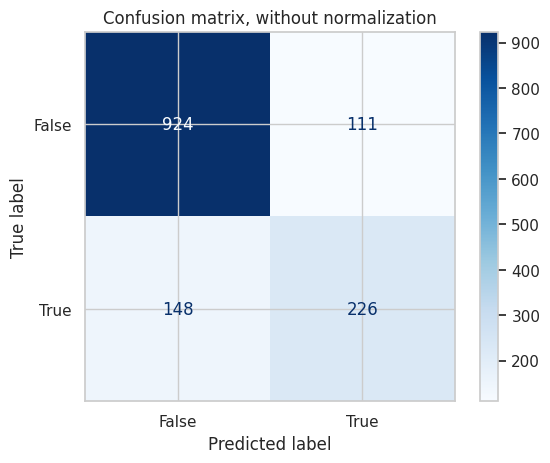



Normalized confusion matrix
[[0.89275362 0.10724638]
 [0.39572193 0.60427807]]


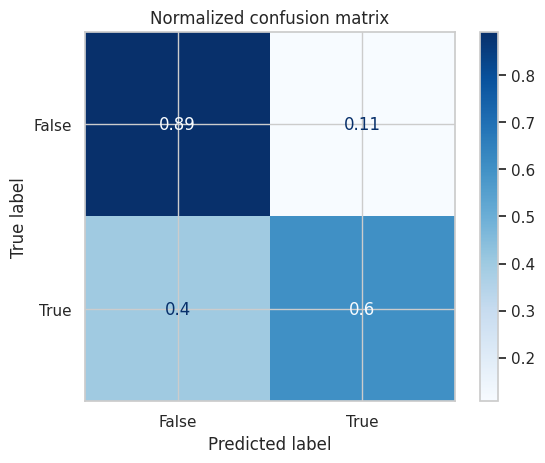

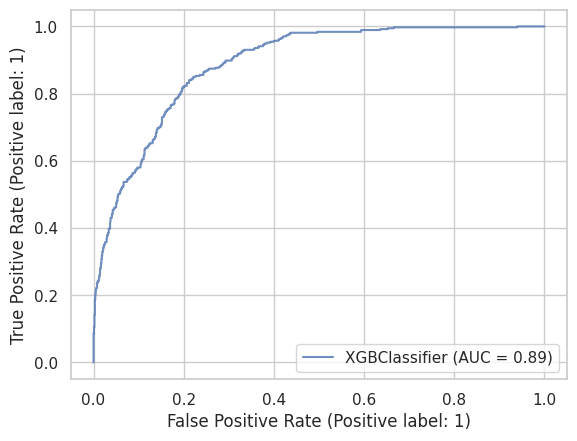

In [ ]:
sel_k = SelectKBest(f_classif, k=39)

X_train_xgb_k = sel_k.fit_transform(X_train_norm, y_train)
X_test_xgb_k_norm = sel_k.transform(X_test_norm)

sorted(dict(zip(sel_k.get_feature_names_out(), sel_k.scores_)).items(), reverse=True, key=lambda x: x[1] )

parameter_space = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [16, 32, 64, 100],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
}

xgb_gscv =xgb.XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2)
cv = StratifiedKFold(5)

rscv_xgb = GridSearchCV(
    xgb_gscv,
    param_grid=parameter_space,
    verbose=3,
    cv=cv,
    scoring='accuracy'
)


# fit Search
start = time()
rscv_xgb.fit(X_train_xgb_k, y_train=='Yes')
end = time()
print(
    "GridSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((end - start), n_iter_search)
)

# Print Report
report(rscv_xgb.cv_results_)

best_xgb_k = rscv_xgb.best_estimator_

best_xgb_k_preds = best_xgb_k.predict(X_test_xgb_k_norm)
print('Best parameters found:\n', rscv_xgb.best_params_)

accuracy = accuracy_score(y_test=='Yes', best_xgb_k_preds)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test=='Yes', best_xgb_k_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test=='Yes', best_xgb_k.predict_proba(X_test_xgb_k_norm)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_xgb_k, X_test_xgb_k_norm, y_test=='Yes')

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(best_xgb_k, X_test_xgb_k_norm, y_test=='Yes', alpha=0.8)


# Adaboost

## Finding the best k features with cross validation for AdaBoost

In [ ]:
def cv_abdt_kbest(k_features):
  sel_k = SelectKBest(f_classif, k=k_features)
  X_train_k = sel_k.fit_transform(X_train_norm, y_train)
  X_test_k = sel_k.transform(X_test_norm)

  abdt = AdaBoostClassifier()

  cv = StratifiedKFold(5)

  res = cross_validate(abdt, X_train_k, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2 , return_estimator=True, return_train_score=True)
  print(f'K-features: {k_features} Accuracy: {res["train_score"].mean()}')
  return res["train_score"].mean()

abdt_scores = {}
for k in range(1, len(X_train.columns)+1):
  abdt_scores[k] = cv_abdt_kbest(k)

print(sorted(abdt_scores.items(), key=lambda x: x[1], reverse=True)[:20])
plt.plot(abdt_scores.values())

[(46, 0.8434503736571466),
 (47, 0.8434503736571466),
 (48, 0.8434503736571466),
 (49, 0.8434503736571466),
 (50, 0.8434503736571466),
 (68, 0.8434060277722379),
 (69, 0.8434060277722379),
 (70, 0.8434060277722379),
 (44, 0.843405919491498),
 (45, 0.843405919491498),
 (51, 0.843317276940199),
 (52, 0.843317276940199),
 (59, 0.8429178588212085),
 (39, 0.8427403670008342),
 (40, 0.8427403670008342),
 (41, 0.8427403670008342),
 (58, 0.8426960309596293),
 (42, 0.8426959915848148),
 (43, 0.8426959915848148),
 (60, 0.8426516063250915)]

## Default AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate

abdt = AdaBoostClassifier()

abdt.fit(X_train, y_train)
abdt_y_pred = abdt.predict(X_test)

accuracy = accuracy_score(y_test, abdt_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, abdt_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, abdt.predict_proba(X_test)[:, 1]))
print("\n")


# Plot confusion matrix
# plot_confusion_matrix(abdt, X_test, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(abdt, X_test, y_test, alpha=0.8)


Accuracy: 0.8360539389638041
Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.90      0.89      1035
         Yes       0.70      0.66      0.68       374

    accuracy                           0.84      1409
   macro avg       0.79      0.78      0.79      1409
weighted avg       0.83      0.84      0.83      1409

ROC AUC Score:
0.8930507117207886




In [ ]:
sel_k = SelectKBest(f_classif, k=44)
X_train_ada_k = sel_k.fit_transform(X_train, y_train)
X_test_ada_k = sel_k.transform(X_test)

abdt_k = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=200, learning_rate=0.6)

abdt_k.fit(X_train_ada_k, y_train)
abdt_y_pred = abdt_k.predict(X_test_ada_k)

accuracy = accuracy_score(y_test, abdt_y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, abdt_y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, abdt_k.predict_proba(X_test_ada_k)[:, 1]))
print("\n")


# Plot confusion matrix
# plot_confusion_matrix(abdt, X_test, y_test)

# Plot ROC curve
# metrics.RocCurveDisplay.from_estimator(abdt, X_test, y_test, alpha=0.8)

Accuracy: 0.836763662171753
Classification Report:
              precision    recall  f1-score   support

          No       0.89      0.89      0.89      1035
         Yes       0.70      0.68      0.69       374

    accuracy                           0.84      1409
   macro avg       0.79      0.79      0.79      1409
weighted avg       0.84      0.84      0.84      1409

ROC AUC Score:
0.8960409723836833




In [ ]:
sel_k = SelectKBest(f_classif, k=44)
X_train_ada_k = sel_k.fit_transform(X_train, y_train)
X_test_ada_k = sel_k.transform(X_test)

parameter_space = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'algorithm' : ['SAMME']
}

ada_rscv = AdaBoostClassifier(random_state=42)
cv = StratifiedKFold(5)

# run randomized search
n_iter_search = 35
rscv_ada = RandomizedSearchCV(
    ada_rscv, param_distributions=parameter_space, n_iter=n_iter_search, verbose=1, cv=cv
)

# fit Search
start = time()
rscv_ada.fit(X_train_ada_k, y_train)
end = time()
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((end - start), n_iter_search)
)

# Print Report
report(rscv_ada.cv_results_)

best_ada_k = rscv_ada.best_estimator_

best_ada_k_preds = best_ada_k.predict(X_test_ada_k)
print('Best parameters found:\n', rscv_ada.best_params_)
accuracy_score(y_test, best_ada_k_preds)

accuracy = accuracy_score(y_test, best_ada_k_preds)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, best_ada_k_preds))
print("ROC AUC Score:")
print(roc_auc_score(y_test, best_ada_k.predict_proba(X_test_ada_k)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_ada_k, X_test_ada_k, y_test)

# Plot ROC curve
metrics.RocCurveDisplay.from_estimator(best_ada_k, X_test_ada_k, y_test, alpha=0.8)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


KeyboardInterrupt: 